# What data tells us about how Airbnb is being used in Seattle. 


# Introduction

Airbnb is an online marketplace which lets you rent out properties or spare rooms to guests. It is the world's biggest accommodation sharing website and is currently worth more than any hotel chain in the world.
One of the main challenges for hosts as well as customers at Airbnb is to determine what is the optimal price to charge or pay for a listing. Can we, as data scientists, do some analysis of the Airbnb listings to get an overview of how Airbnb is being used and provide some insights in this regard ?
Airbnb, however, does not provide open data dump for us to work on. We can utilize the data made available by an independent entity named [Inside Airbnb](http://insideairbnb.com/) to analyze and draw insights of our own.

In this project, we will look at 2016 Airbnb listing data for Seattle and try to find answer for below questions:.

*  What are the busiest times of the year when you visit Seattle? When is it the most and least expensive to stay, on average, at an Airbnb listing?
*  What are the neighborhoods with the highest no of listings?Where is it the most and least expensive to stay, on average?
*  What is the relationship between popularity of a listing and its price?
*  What are some properties of the listings that can be used to predict price?



In [1]:
# Import required packages
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import folium
from folium.plugins import FloatImage

# Modeling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

# Set a few plotting defaults
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

# Data understanding

In [2]:
# Read the data
listings = pd.read_csv('seattle/listings.csv')
calendar = pd.read_csv('seattle/calendar.csv')
reviews = pd.read_csv('seattle/reviews.csv')

Get familiar with the data.

### Calendar

In [3]:
# Total number of records and columns
calendar.shape

(1393570, 4)

In [4]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


This dataset has details related to availability and pricing for all the listings throughout the year. Another thing to note here is that the date column is not in date format.

In [5]:
# Take a look at the first few rows of the dataset
calendar.head(2)

listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00

In [6]:
print("Calendar contains data related to {} listings, for {} days, starting from {} till {}".format(len(calendar.listing_id.unique()),len(calendar.date.unique()),calendar.date.min(),
                                                                          calendar.date.max()))

Calendar contains data related to 3818 listings, for 365 days, starting from 2016-01-04 till 2017-01-02


### Listings

In [7]:
# Total number of records and columns
listings.shape

(3818, 92)

In [8]:
# Take a look at the first few rows of the dataset
listings.head(2)

id                          listing_url       scrape_id last_scraped  \
0  241032  https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1  953595  https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   

                                 name  \
0        Stylish Queen Anne Apartment   
1  Bright & Airy Queen Anne Apartment   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   

                               neighborhood_overview  \
0                                                NaN   
1  Queen Anne is a wonderful, truly functional vi...   

                                               notes  \
0                                                NaN   
1  What's up with the free pillows?  Our home was...   

                                             transit  \
0                                                NaN   
1  Convenient bus stops are just down the block, ...   

                                       thumbnail_url  \
0                                                NaN   
1  https://a0.muscache.com/ac/pictures/14409893/f...   

                                          medium_url  \
0                                                NaN   
1  https://a0.muscache.com/im/pictures/14409893/f...   

                                         picture_url  \
0  https://a1.muscache.com/ac/pictures/67560560/c...   
1  https://a0.muscache.com/ac/pictures/14409893/f...   

                                      xl_picture_url  host_id  \
0                                                NaN   956883   
1  https://a0.muscache.com/ac/pictures/14409893/f...  5177328   

                                    host_url host_name  host_since  \
0   https://www.airbnb.com/users/show/956883     Maija  2011-08-11   
1  https://www.airbnb.com/users/show/5177328    Andrea  2013-02-21   

                        host_location  \
0  Seattle, Washington, United States   
1  Seattle, Washington, United States   

                                          host_about  host_response_time  \
0  I am an artist, interior designer, and run a s...  within a few hours   
1  Living east coast/left coast/overseas.  Time i...      within an hour   

  host_response_rate host_acceptance_rate host_is_superhost  \
0                96%                 100%                 f   
1                98%                 100%                 t   

                                  host_thumbnail_url  \
0  https://a0.muscache.com/ac/users/956883/profil...   
1  https://a0.muscache.com/ac/users/5177328/profi...   

                                    host_picture_url host_neighbourhood  \
0  https://a0.muscache.com/ac/users/956883/profil...         Queen Anne   
1  https://a0.muscache.com/ac/users/5177328/profi...         Queen Anne   

   host_listings_count  host_total_listings_count  \
0                  3.0                        3.0   
1                  6.0                        6.0   

                                  host_verifications host_has_profile_pic  \
0               ['email', 'phone', 'reviews', 'kba']                    t   
1  ['email', 'phone', 'facebook', 'linkedin', 're...                    t   

  host_identity_verified                                             street  \
0                      t      Gilman Dr W, Seattle, WA 98119, United States   
1                      t  7th Avenue West, Seattle, WA 98119, United States   

  neighbourhood neighbourhood_cleansed neighbourhood_group_cleansed     city  \
0    Quee

The listings dataset contains details related to 3818 listings , their pricings, host details, locations, amenities and so on. While there are 92 columns in total, we will be looking only at a selected few to do our analysis. Here are some of the columns we will be looking at for our analysis:

* id  :  Unique identifier for each listing. It is a common column for all the three datasets(represented as listing_id in the other two datasets).

* neighborhood_cleansed  :  String representing the name of the  neighborhood of a listing.

* price  :  The nightly price listed by the host in USD. 

* number_of_reviews  :  Total no. of customer reviews for a listing.

* latitude,longitude  :  Values for identifying the location of a listing in a map.

### Reviews

In [9]:
# Total number of records and columns
reviews.shape

(84849, 6)

In [10]:
# Take a look at the first few rows of the dataset
reviews.head(2)

listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   

                                            comments  
0  Cute and cozy place. Perfect location to every...  
1  Kelly has a great room in a very central locat...

Comments column in the Reviews dataset contains customer reviews for their stay at Airbnb homes.

In [11]:
missing_reviews = listings.shape[0] - len(reviews['listing_id'].unique())
print('Reviews are missing for {} listings'.format(missing_reviews))

Reviews are missing for 627 listings


# Exploratory Data analysis

**Calendar**

In [12]:
print(calendar['listing_id'].value_counts().unique())


[365]


The calendar has listing availability and price details for all 365 days.

In [13]:
calendar.isnull().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

Price has missing values. Let's dig further into this.

In [14]:
calendar.groupby('available').price.count()

available
f         0
t    934542
Name: price, dtype: int64

The available column has two possible values - t for available and f for not available.  For available value of f , the price value is missing, which makes sense. We will convert the t and f values to 1 and 0 respectively and then take average of them to derive average availability  on a daily basis.

In [15]:
calendar['available'] = calendar.available.map(lambda x: 1 if x == 't' else 0)

In [16]:
# convert date column to datetime format
calendar.date = pd.to_datetime(calendar.date)

In [17]:
# clean up the price column
calendar['price'] = calendar['price'].str.replace('$', '').str.replace(',', '')
calendar['price'] = calendar['price'].astype(float)

Now, let's dive deeper into the calendar data to seek answers for some of the questions we had.

### **What are the busiest times of the year when you visit Seattle?** **When is it the most and least expensive to stay, on average, at an Airbnb listing?**









To get an intuition about how the %occupancy and average prices change throughout the year, we will use the 'month' column to group price and occupancy.

First, we will derive a new calendar containing daily average price and percentage occupancy for a listing.

In [18]:
# Derive a new calendar containing average price and listing availability by day
calendar_365 = calendar.groupby(
    'date')['available', 'price'].mean().reset_index()
calendar_365.rename(
    columns={'price': 'average_price', 'available': 'vacancy'}, inplace=True)
# Create new column which captures average %occupancy in a day
calendar_365['occupancy'] = (1 - calendar_365['vacancy']) * 100

# Split columns for 'day of week' and 'month'
calendar_365['dayofweek'] = calendar_365.date.dt.weekday_name.str[:3]
calendar_365['month'] = calendar_365.date.dt.month_name().str[:3]

In [19]:
# Take a peek at the new calendar
calendar_365.sample()

date   vacancy  average_price  occupancy dayofweek month
348 2016-12-17  0.737297     140.840853  26.270299       Sat   Dec

In [20]:
def plot_calendar(groupby_col, agg_col):
    '''
    INPUT:
    groupby_col - column name to be used for grouping values
    agg_col - column name for values to be grouped

    OUTPUT:
    Plot displaying the grouped values

    '''
    df_index = list(calendar_365[groupby_col].unique())
    grouped_df = calendar_365.groupby(
        groupby_col)[agg_col].mean().reindex(df_index)

    plt.plot(grouped_df)
    plt.ylabel(agg_col.replace('_', ' ').title())
    plt.title(" {} by {}".format(agg_col.replace('_', ' ').title(),
                                 groupby_col.title()), fontsize=18, fontweight='bold')
    # points on the x axis where you want the label to appear
    ticks = list(range(len(df_index)))
    labels = df_index
    plt.xticks(ticks, labels)
    plt.show()

In [21]:
style.use('seaborn-poster')  # sets the size of the charts
style.use('fivethirtyeight')  # sets the visualization style

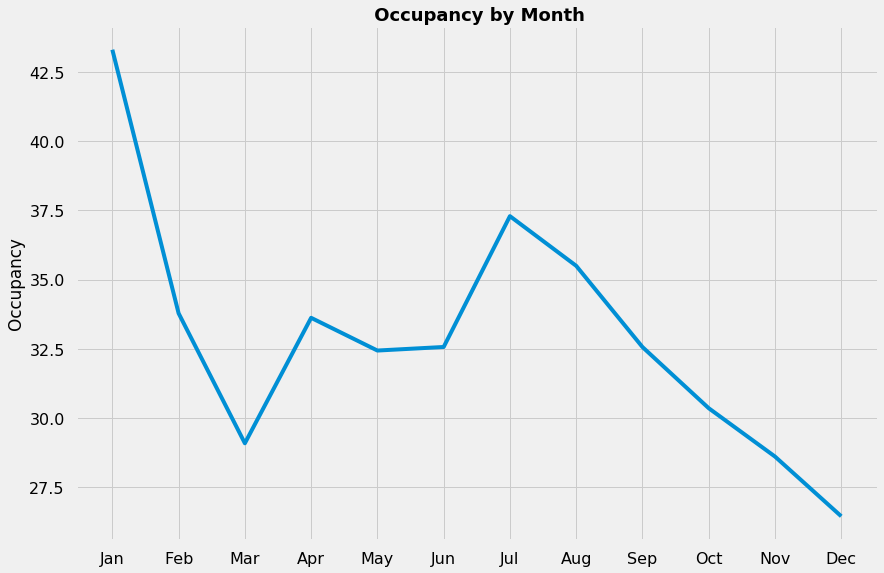

In [22]:
# Plot monthly average occupancy percentage to visualize how they vary throughout the year.
plot_calendar('month', 'occupancy')

The Airbnb homes in Seattle seems to be at its busiest during the beginning of the year. Then it takes a plunge towards the end of March, and peaks again during July-Aug months.

In [23]:
# Plot monthly average price to visualize how they vary throughout the year.
plot_calendar('month', 'average_price')

Airbnb prices at Seattle starts peaking around June, achieving maximum business during July-Aug months. Prices are at its cheapest during Jan-Feb.
On an average, a visitor has to pay $35 more for a night's stay during the peak season, than what he would pay during off season.

The high occupancy percentage in January does seem a bit puzzling. Going by simple price and occupancy correlation, one would expect July-Aug to be the busiest period. We would need to look at data from different years, to be able to reach a better conclusion on this.

Now let's see how the %occupancy and average prices change within a week. We will use the newly created 'dayofweek' column to group all prices and occupancy.

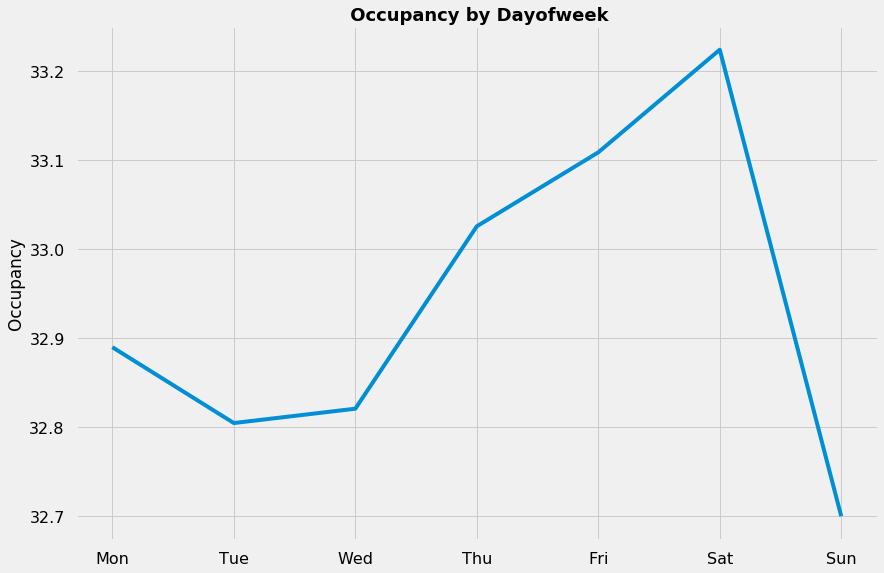

In [24]:
plot_calendar('dayofweek', 'occupancy')

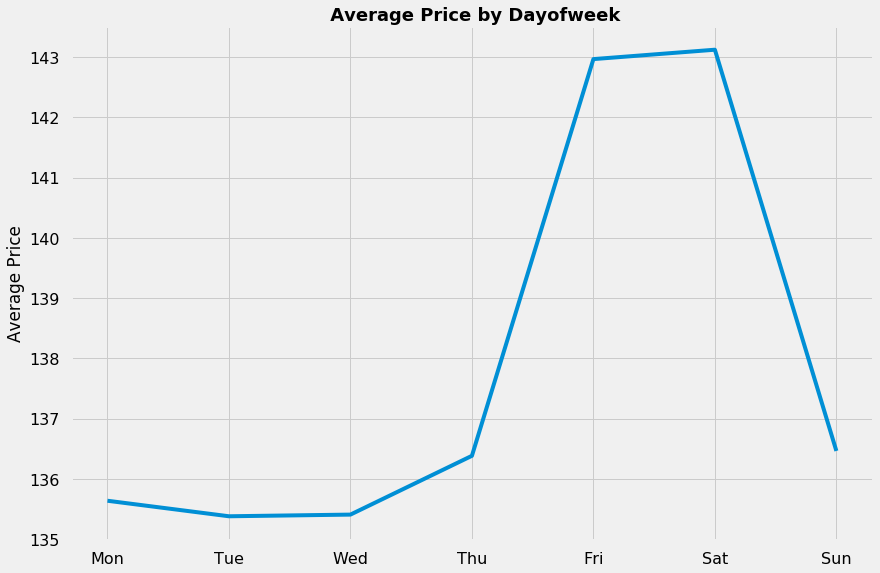

In [25]:
plot_calendar('dayofweek', 'average_price')

The pricing peaks along with occupancy towards the weekend. This is as per expectation.

**Reviews**

In [26]:
reviews.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64

Reviews are missing for some of the listings.

In [27]:
reviews.sample(2)

listing_id        id        date  reviewer_id reviewer_name  \
23787     5078876  48797243  2015-09-28     42626506       Jessica   
73639      444221  10973106  2014-03-15     12338220         Kevin   

                                                comments  
23787  Our hosts made us feel incredible welcomed fro...  
73639                                 Another great stay

**Listings**

In [28]:
listings[['id', 'price', 'neighbourhood_cleansed',
          'number_of_reviews']].sample(1)

id   price neighbourhood_cleansed  number_of_reviews
1593  6993978  $80.00             First Hill                 13

In [29]:
listings[['id', 'price', 'neighbourhood_cleansed',
          'number_of_reviews']].isnull().sum()

id                        0
price                     0
neighbourhood_cleansed    0
number_of_reviews         0
dtype: int64

There are no missing values for the columns we will be exploring for data  analysis. However, the price column needs to be cleaned of ''$'' and  comma.

In [30]:
# Clean up price column
listings.price = listings.price.str.replace('$', '').str.replace(',', '')
listings['price'] = listings['price'].astype(float)

Now, let's have a look at the pricing distribution.

In [31]:
sns.boxplot(listings.price, orient='v').set_title(
    'Boxplot for listings.price.')

Text(0.5,1,'Boxplot for listings.price.')

In [32]:
listings['price'].describe()

count    3818.000000
mean      127.976166
std        90.250022
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64

The price ranges from 20 to 1000, with the median price being 100. The mean price is 27% higher than the median due to the presence of some high priced outliers. For our analysis, we will remove the top outliers and consider only those listings that have prices less than 600. Also, to get the central tendency of the price distribution in neighborhoods, we will consider median instead of mean.

In [33]:
print('There are {} listings in the 600 to 1000 price bracket'.format(
    len(listings[listings.price >= 600])))

There are 18 listings in the 600 to 1000 price bracket


In [34]:
# Remove top outliers from the dataframe
listings = listings[listings.price < 600]

Text(0.5,1,'Histogram for listings price after removing top outliers')

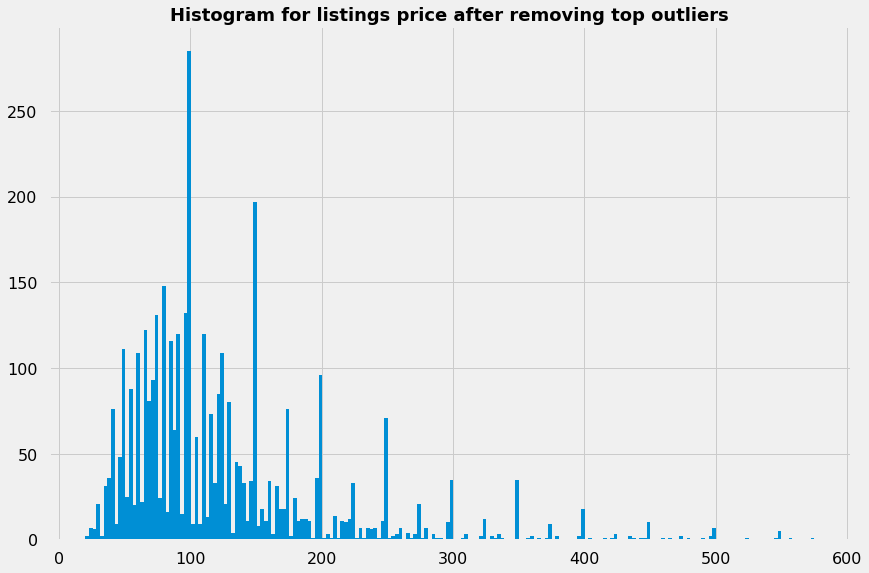

In [35]:
# Plot price distribution
listings.price.hist(bins=200)
plt.title('Histogram for listings price after removing top outliers',
          fontsize=18, fontweight='bold')

### **Which neighborhoods have the most listings?**

Next we will get the count of listings by neighborhood and plot top neighborhoods by listing count. We will also look at the density of listings in different neighborhoods to get a better intuition about top neighborhoods.

In [36]:
print('There are {} neighborhoods in the listings data'.format(
    len(listings.neighbourhood_cleansed.unique())))

There are 87 neighborhoods in the listings data


In [37]:
def group_plot(df, groupby_col, agg_col, plot_type, top_k=10):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    groupby_col - column name to be used for grouping values
    agg_col - column name for values to be grouped
    plot_type - plot type to be used for displaying the grouped values
    top_k - No of top grouped values to be displayed in the plot

    OUTPUT:
    Plot to display grouped values

    '''

    if plot_type == 'count':

        # Count plot for top neighborhoods based on listing counts
        if agg_col == 'id':
            grouped_df = df.groupby(groupby_col)[agg_col].count()
            order_index = grouped_df.sort_values(ascending=False).index[:top_k]
            splot = sns.countplot(x=groupby_col, data=df,
                                  palette="Set1", order=order_index)

            for p in splot.patches:
                splot.annotate(format(p.get_height(), '.0f'), (p.get_x()+p.get_width()/2., p.get_height()),
                               rotation=90, ha='center', va='bottom', xytext=(0, 10), textcoords='offset points')

            plt.xlabel('Neighborhood')
            plt.ylabel('Listings count')
            plt.title('Top neighborhoods based on listing counts',
                      fontsize=18, fontweight='bold')

        # Count plot for top neighborhoods price distribution
        elif agg_col == 'price_bins':
            bins = [0, 101, 201, 301, 401, 501, 1000]
            group = ['1-100', '101-200', '201-300',
                     '301-400', '400-500', '500+']

            df['price_bins'] = pd.cut(df['price'], bins, labels=group)

            grouped_df = df.groupby(groupby_col)['price'].median()
            order_index = grouped_df.sort_values(ascending=False).index[:top_k]
            splot = sns.countplot(x=groupby_col, data=df, hue='price_bins',
                                  orient='h', palette="Set1", order=order_index)
            for p in splot.patches:
                splot.annotate(format(p.get_height(), '.0f'), (p.get_x()+p.get_width()/2., p.get_height()),
                               rotation=90, ha='center', va='bottom', xytext=(0, 10), textcoords='offset points')

            plt.xlabel('Neighborhood')
            plt.ylabel('Price bins count')
            plt.title('Top neighborhoods price distribution',
                      fontsize=18, fontweight='bold')
            plt.legend(loc='upper right')

    # Box plot for top neighborhoods based on price
    elif plot_type == 'box':
        grouped_df = df.groupby(groupby_col)[agg_col].median()
        order_index = grouped_df.sort_values(ascending=False).index[:top_k]
        sns.boxplot(x=groupby_col, y=agg_col, data=df,
                    palette="Set1", order=order_index)

        plt.xlabel('Neighborhood')
        plt.ylabel('Price')
        plt.title('Top neighborhoods based on listing prices',
                  fontsize=18, fontweight='bold')

    plt.xticks(
        rotation=45,
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large'
    )

Let's get the top 25 neighborhoods.

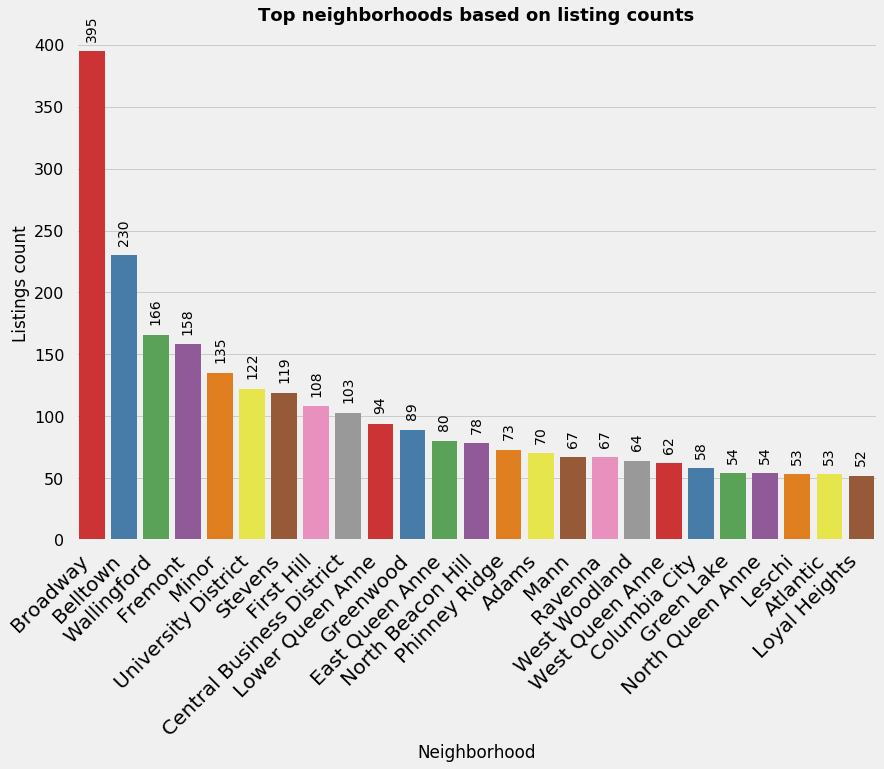

In [38]:
group_plot(listings, 'neighbourhood_cleansed', 'id', 'count', 25)

As depicted in the chart above, Broadway, Belltown and Wallingford are the top 3 neighborhoods based on listings count.
Listings count, however, provide only half the picture, as some neighborhoods may have bigger counts due to larger size. To have a better idea of top neighborhoods, we need to look at the listing density, i.e., how concentrated or spread out the listings are in a neighborhood. To be able to explore this visually, we will plot the geographic coordinates of the listings on a map.

In [39]:
def plot_top_neighborhood_locations(df, groupby_col):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest

    OUTPUT:
    Map displaying the listings locations for top neighborhoods

    '''
    # Seattle latitude and longitude values
    latitude = 47.6062
    longitude = -122.3321

    # To differentiate neighborhoods in t he map
    color_list = ['red', 'blue', 'gray', 'darkred', 'lightgreen',
                  'orange', 'black', 'cadetblue', 'darkgreen', 'purple']

    # filter the listings data for only top 10 neighbourhoods
    grouped_df = df.groupby(groupby_col)['id'].count()
    top_nbrhd_list = list(grouped_df.sort_values(ascending=False).index[:10])
    top_nbrhd = listings[listings[groupby_col].isin(top_nbrhd_list)]

    # create color mapping for each neighborhood
    colormap = dict(zip(top_nbrhd_list, color_list))

    # create map and display it
    seattle_map = folium.Map(location=[latitude, longitude], zoom_start=12)

    # instantiate a feature group for the incidents in the dataframe
    incidents = folium.map.FeatureGroup()

    # loop through the listings and add each to the incidents feature group
    for lat, lng, nbrhd in zip(top_nbrhd.latitude, top_nbrhd.longitude, top_nbrhd[groupby_col]):
        if nbrhd in colormap:
            nbrhd_color = colormap[nbrhd]
            incidents.add_child(
                folium.vector_layers.CircleMarker(
                    [lat, lng],
                    radius=1.0,  # define how big you want the circle markers to be
                    color=nbrhd_color,
                    fill=False,
                    popup=nbrhd,
                    fill_color='blue',
                    fill_opacity=0.05
                )
            )

    # add incidents to map
    seattle_map.add_child(incidents)
    # add legends to map
    if groupby_col == 'neighbourhood_cleansed':
        image_file = 'https://raw.githubusercontent.com/samardolui/AirbnbSeattle/master/legend_neighborhood.png'
    else:
        image_file = 'https://raw.githubusercontent.com/samardolui/AirbnbSeattle/master/legend_neighborhood_group.png'

    folium.plugins.FloatImage(image_file, bottom=55,
                              left=70).add_to(seattle_map)

    return seattle_map

In [40]:
plot_top_neighborhood_locations(listings, 'neighbourhood_cleansed')

Amongst the top 3 neighborhoods based on listing counts, listing density is more concentrated near Broadway and Belltown, whereas it is more spread out in Wallington. The areas in and around Broadway and Belltown seem to be where most of the listings are located. Let's plot the top neighborhood groups to see if this is indeed the case.

In [41]:
plot_top_neighborhood_locations(listings, 'neighbourhood_group_cleansed')

Our intuition was correct. Neighbourhood groups Capitol Hill, Downtwon which contain Broadway and Belltown respectively, are among the top three neighborhood groups based on listing counts.

### **Where is it the most and least expensive to stay, on average?**

We will use the average price of different neighborhoods to get an intuition about which among them are relatively costlier. The [Law of Large Numbers](https://www.investopedia.com/terms/l/lawoflargenumbers.asp), states that as a sample size grows, its mean gets closer to the average of the whole population. There is a chance that neighbourhoods with handful of listings may come up in top of the charts and in the process misrepresent the overall trend. To prevent that, we will consider only those neighbourhoods with a minimum of 50 listings and ensure each neighbourhood has enough no of samples to represent the true central tendency. The number 50 chosen here is arbitrary, and can be experimented with. Also, since the price column is skewed, we will consider median instead of mean to get the central price values representing the neighbourhoods.

In [42]:
# Filter the data for only those neighbourhoods that has at least 50 listings.
nbrhd_grouped_df = listings.groupby('neighbourhood_cleansed')['id'].count()
top_nbrhd_list = list(
    nbrhd_grouped_df[nbrhd_grouped_df > 50].sort_values(ascending=False).index)
top_nbrhd = listings[listings['neighbourhood_cleansed'].isin(top_nbrhd_list)]

print("{} neighbourhoods have a minimum of 50 listings" .format(len(top_nbrhd_list)))

25 neighbourhoods have a minimum of 50 listings


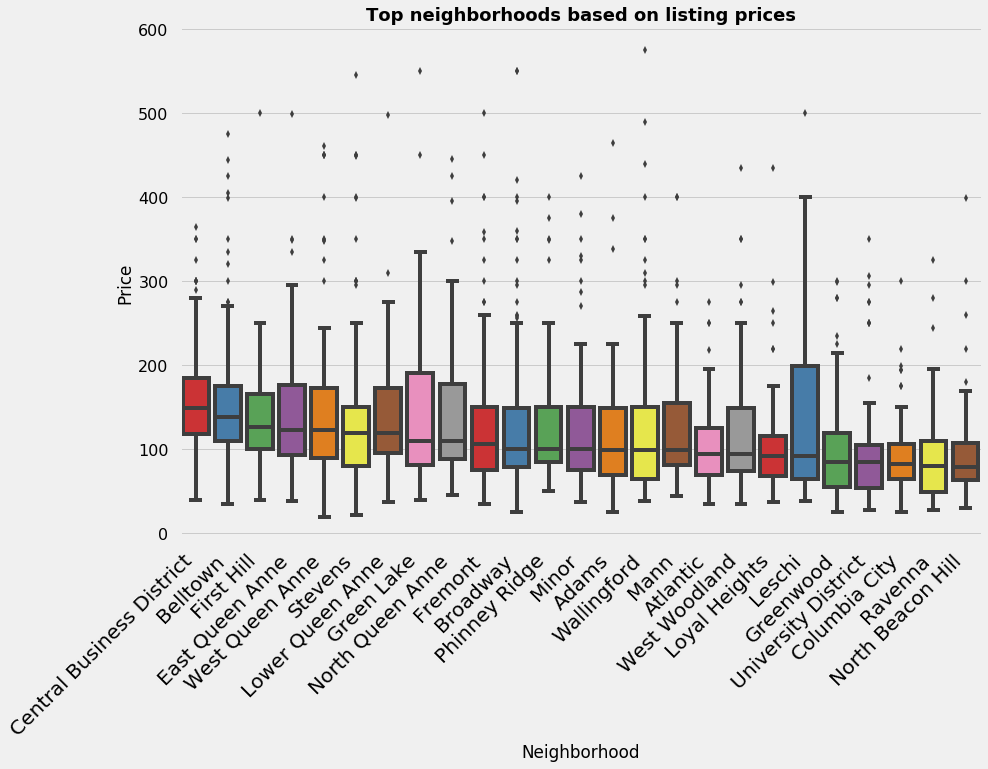

In [43]:
group_plot(top_nbrhd, 'neighbourhood_cleansed', 'price', 'box', 25)

Based on average pricing, Central Business District is the costliest and North Beacon Hill is the cheapest neighborhood.
To have a broader understanding of this, let's also look at the price distribution in each of these neighborhoods.

In [44]:
group_plot(top_nbrhd, 'neighbourhood_cleansed', 'price_bins', 'count', 25)

The costlier neighborhoods have most of their listings in the 101–200 price range, whereas, the rest have most of their listings in the 1–100 price range.
Broadway, which is somewhere around the middle, has almost the same no of listings as Belltown in the 101–200 price range. But, that is offset by even higher no of listings in the 1–100 price range.

### **What is the relationship between popularity of a listing and its price?**

We will use the number_of_reviews column to gauze popularity of the listings.  
The assumption being, more number of reviews correspond to higher demand and popularity. To validate this, we will plot number of reviews and prices together for all the listings data . 

Text(0.5,1,'Price vs Number of Reviews')

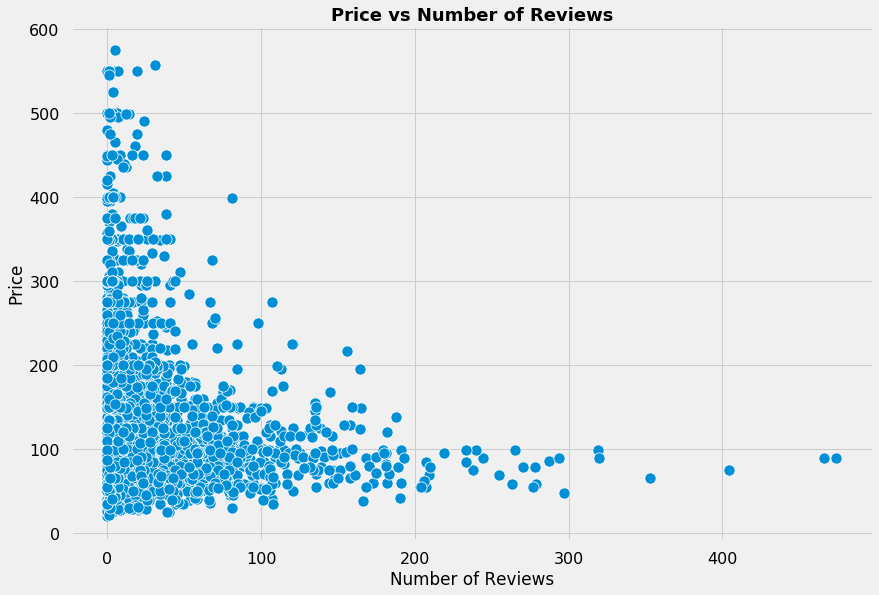

In [45]:
sns.scatterplot(x=listings['number_of_reviews'], y=listings['price'])
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.title('Price vs Number of Reviews', fontsize=18, fontweight='bold')

There seems to be somewhat weak negative correlation between the two. 

Now, let's see how this translates at the neighborhood level.
We would expect the neighborhoods with less average price to be more popular. 

In [46]:
def plot_price_vs_popularity(df, top_k):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    top_k - No of top neighborhoods to be displayed in the plot

    OUTPUT:
    Plot to display price vs popularity relation
    '''
    x = df.groupby('neighbourhood_cleansed')[
        'number_of_reviews'].mean().sort_index()[:top_k]
    y = df.groupby('neighbourhood_cleansed')[
        'price'].mean().sort_index()[:top_k]
    n = (x.reset_index()).neighbourhood_cleansed.tolist()[:top_k]
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.scatter(x, y, c=y, cmap=sns.diverging_palette(
        220, 20, sep=20, as_cmap=True), s=200)

    for i, txt in enumerate(n):
        ax.annotate(txt, (x[i], y[i]), fontsize=12)

    plt.xlabel('Average Number of Reviews')
    plt.ylabel('Average Price')
    plt.title('Average Price and Popularity of Listings',
              fontsize=18, fontweight='bold')

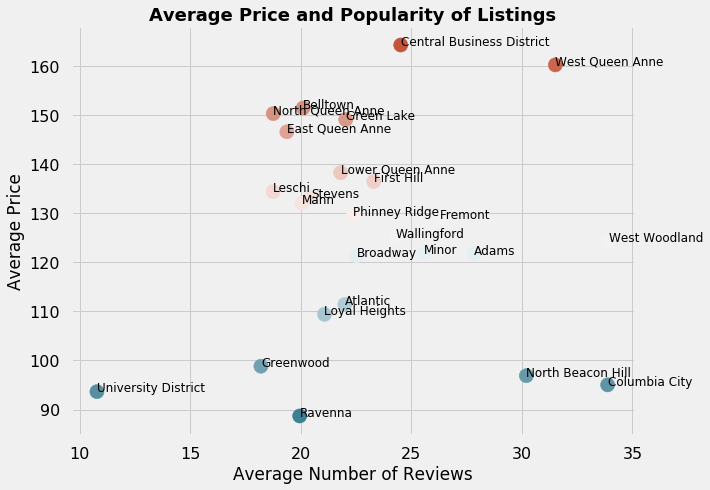

In [47]:
plot_price_vs_popularity(top_nbrhd, 25)

There seems to be no correlation between average prices and popularity of a neighbourhood.  One of the possible reason could be less no of sample point per neighbourhood as some of the neighborhoods have as less as 50 listings. 

Let's plot only the top 10 neighborhoods to include a larger no of samples per neighborhood and see if there is any conclusive pattern.

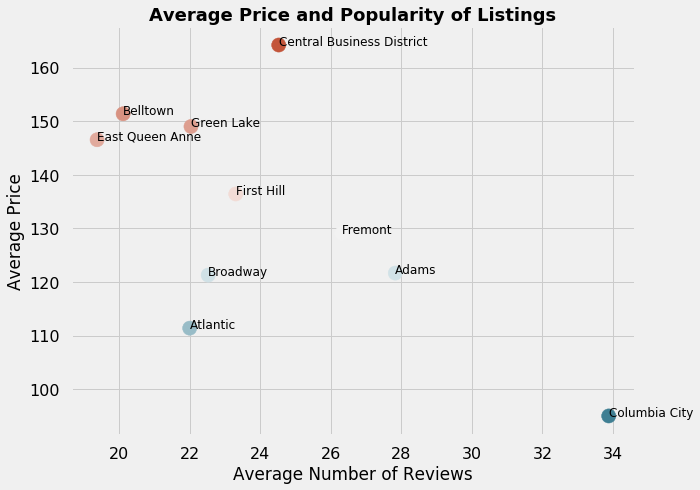

In [48]:
plot_price_vs_popularity(top_nbrhd, 10)

It seems, there is a negative correlation between the average prices and popularity of a neighborhood. Also, it is evident from the visualization, the relation is not a strong one, as some of the neighborhoods bucked the trend

###  **What are some properties of the listings that can be used to predict price?**


For this, we will build a predictive model using different attributes of the listings. The idea is to train a model on the listing data and then find out the most important predictive features that contributed to the model. But, first, we need to clean up the data and evaluate which are the features we can use for model building.

# Prepare Data

We will do some data-preprocessing and feature engineering in here.

The listings dataset has 92 columns. Not all of them are helpful in building machine learning models.
We can ignore some of the columns -

*  Columns like listing id which has different values in each row and used as a row identifier 

*  Nominal columns like name,summary which don't contribute in predicting the price value

*  Columns with low variability,i.e,  most of the data is same throughout the column.

We are going to consider below features for our model building. For certain correlated columns like review_scores_rating, review_scores_value, review scores_location we have considered only one of those to 
prevent multicollinearity. [Multicollinearity is a problem](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/) because independent variables should be independent.

In [49]:
features = ['cancellation_policy', 'is_location_exact', 'accommodates', 'reviews_per_month', 'property_type', 'price',
            'host_total_listings_count', 'extra_people', 'calculated_host_listings_count', 'guests_included',
            'review_scores_rating', 'host_response_time', 'number_of_reviews', 'host_is_superhost', 'room_type',
            'instant_bookable', 'amenities', 'host_identity_verified', 'host_has_profile_pic', 'security_deposit',
            'host_listings_count', 'requires_license', 'neighbourhood_group_cleansed', 'neighbourhood_cleansed',
            'minimum_nights', 'bathrooms', 'require_guest_phone_verification', 'cleaning_fee']

In [50]:
data = listings[features].copy()

**Data cleaning and Feature Engineering**

Cleaning_fee, security_deposit, extra_people are price related columns and need to be cleaned.

In [51]:
data.cleaning_fee = data.cleaning_fee.str.replace('$', '').str.replace(',', '')
data.cleaning_fee = data.cleaning_fee.astype(float)

data.security_deposit = data.security_deposit.str.replace(
    '$', '').str.replace(',', '')
data.security_deposit = data.security_deposit.astype(float)

data.extra_people = data.extra_people.str.replace('$', '').str.replace(',', '')
data.extra_people = data.extra_people.astype(float)

We are going to drop some of the columns based on missing value threshold. A missing value threshold value of 0.4 suggests columns that has more than 40% missing values will be dropped.

In [52]:
# Diplay columns along with missing values percentage
data.isnull().mean().sort_values(ascending=False)[:15]*100

security_deposit             51.289474
cleaning_fee                 27.052632
review_scores_rating         17.000000
reviews_per_month            16.473684
host_response_time           13.657895
bathrooms                     0.421053
host_has_profile_pic          0.052632
host_total_listings_count     0.052632
host_identity_verified        0.052632
host_is_superhost             0.052632
host_listings_count           0.052632
property_type                 0.026316
amenities                     0.000000
is_location_exact             0.000000
accommodates                  0.000000
dtype: float64

In [53]:
def drop_missing_value_cols(df, missing_thres=0.4):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest

    OUTPUT:
    new_df - a dataframe with missing values columns dropped
    '''
    # Create a copy to prevent modifying slices of original dataframe
    new_df = df.copy()

    # Drop columns having more than a certain percentage of missing values
    missing_thres = len(new_df) - (len(new_df) * missing_thres)
    new_df = new_df.dropna(thresh=missing_thres, axis=1)

    return new_df

In [54]:
# Drop columns that has more than 20% missing values
missing_thres = 0.2
data_clean = drop_missing_value_cols(data, missing_thres)

We will impute the missing values for the rest of the columns.

In [55]:
# Identify numerical features
num_cols = data_clean.select_dtypes(exclude='object').columns
# Identify categorical columns
cat_cols = data_clean.select_dtypes(include='object').columns

# Impute numerical features with median and categorical features with mode
data_clean[cat_cols] = data_clean[cat_cols].apply(
    lambda col: col.fillna(col.mode()[0]))
data_clean[num_cols] = data_clean[num_cols].apply(
    lambda col: col.fillna(col.median()))

The amenities column has useful information which can be used for predictive modeling. However, it is not useful in its current format.

We can either
a) split the various amenities into separate columns or 
b) create a new feature that contains no. of amenities provided under the listing. 

For our case, we will follow the second approach.

In [56]:
data_clean['number_of_amenities'] = data_clean['amenities'].apply(
    lambda x: len(x.replace('{', '').replace('}', '').split(',')))

**Feature selection**

In [57]:
def get_low_var_cols(df, thres=90):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    thres - percentage threshold value for identifying low variability columns
    OUTPUT:
    low_var_cols - list of low variability columns identified 
    '''
    low_var_cols = []

    for col in df.columns:
        percent_count = df[col].value_counts()/len(df)*100
        if percent_count.max() > thres:
            low_var_cols.append(col)

    return low_var_cols

In [58]:
# Identify columns that has same data across 90% of the rows
variance_thres = 90
low_var_cols = get_low_var_cols(data_clean, variance_thres)
print('{} are columns with same data across 90% of the rows'.format(
    str(low_var_cols)[1:-1]))

'host_has_profile_pic', 'requires_license', 'require_guest_phone_verification' are columns with same data across 90% of the rows


In [59]:
# Drop the id columns and low variance columns
drop_cols = low_var_cols
data_clean = data_clean.drop(drop_cols, axis=1)

For numeric features we will select a certain no of columns based on how they correlate with the price.

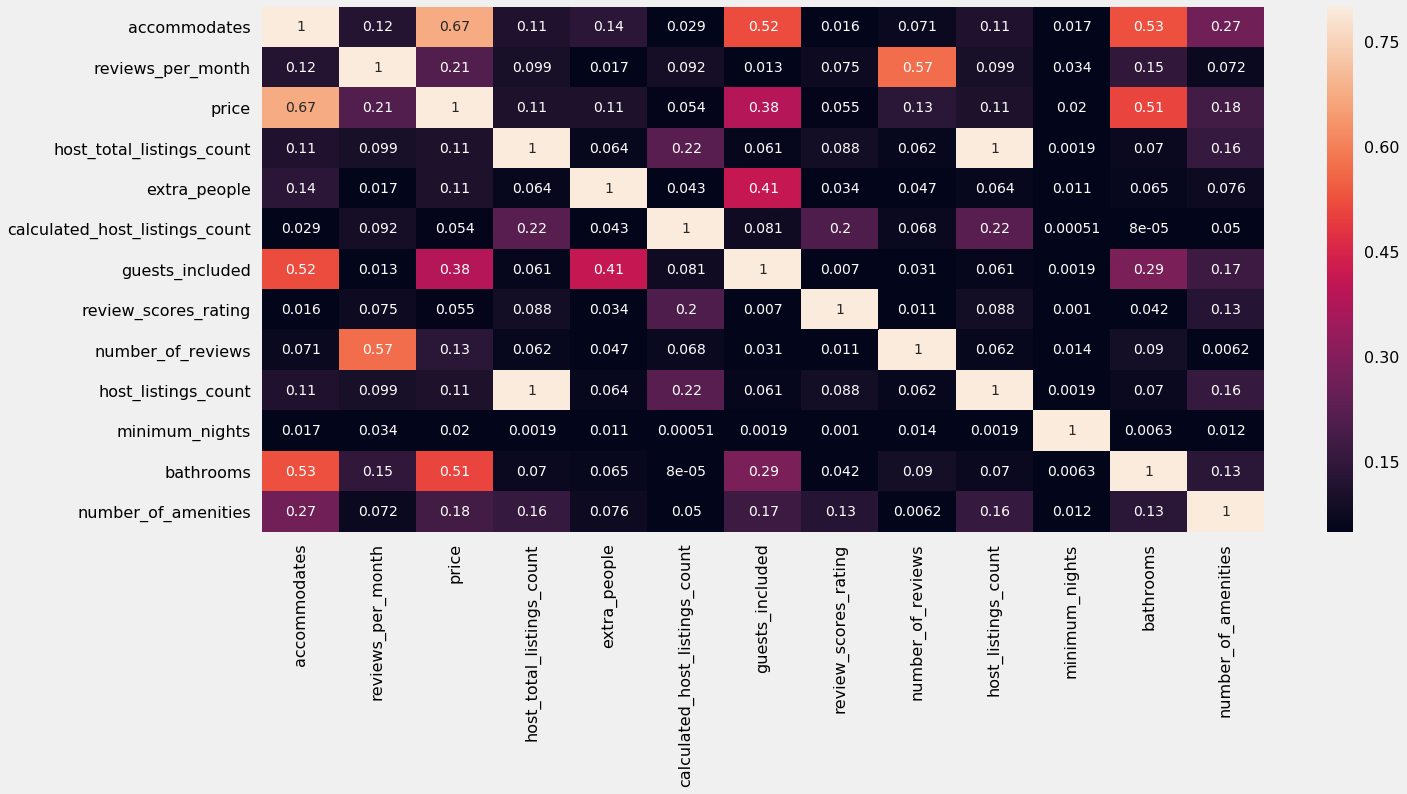

In [60]:
corr_matrix = data_clean.corr()
corr_matrix = abs(corr_matrix)
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corr_matrix, vmax=0.8, vmin=0.05, annot=True)

In [61]:
corr_matrix['price'].sort_values(ascending=False)

price                             1.000000
accommodates                      0.674292
bathrooms                         0.508671
guests_included                   0.382098
reviews_per_month                 0.208632
number_of_amenities               0.183271
number_of_reviews                 0.132412
host_listings_count               0.108460
host_total_listings_count         0.108460
extra_people                      0.107256
review_scores_rating              0.054878
calculated_host_listings_count    0.054235
minimum_nights                    0.019608
Name: price, dtype: float64

Since the list of correlated columns is rather short, we will use all of these for our model, by considering a correlation coefficient threshold of 0.

For categorical features we will consider only those columns that have a maximum of 15 categorical values.  This cutoff again is arbitrary, and can be experimented with.

In [62]:
def select_cat_features(df, cols_list, unique_thres=15):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    cols_list - list of columns to select features from 
    unique_thres - a float value for threshold of no of unique values in categorical features

    OUTPUT:
    selected_features - list of categorical columns selected based on unique values threshold 
    '''
    selected_features = []

    # Select categorical columns based on no of unique values threshold
    for col in cols_list:
        if len(df[col].unique()) <= unique_thres:
            selected_features.append(col)

    return selected_features

In [63]:
def select_features(df, unique_thres=15, corr_thres=0.4):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    unique_thres - a float value for threshold of no of unique values in categorical features
    corr_thres - a float value representing correlation coefficient threshold for identifying the 
               correlated columns

    OUTPUT:
    selected_features - list of features selected for model building
    selected_num_features - list of numerical features selected for model building
    selected_cat_features - list of categorical features selected for model building
    '''

    # Identify numerical features
    num_cols = df.select_dtypes(exclude='object').columns

    # Select numerical columns based on correlation coefficient threshold
    corr = df[num_cols].corr()
    corr_matrix = corr.abs()
    selected_num_features = corr_matrix[(
        corr_matrix['price'] > corr_thres)]['price'].index.tolist()

    # Identify categorical columns
    cat_cols = df.select_dtypes(include='object').columns
    # Select categorical columns based on no of unique values threshold
    selected_cat_features = select_cat_features(df, cat_cols, unique_thres)

    selected_features = selected_num_features + selected_cat_features

    return selected_features, selected_num_features, selected_cat_features

In [64]:
# Get the list of selected features
selected_cols, num_cols, cat_cols = select_features(data_clean, 20, 0)

In [65]:
print("Selected numerical features are:", str(num_cols)[1:-1])

Selected numerical features are: 'accommodates', 'reviews_per_month', 'price', 'host_total_listings_count', 'extra_people', 'calculated_host_listings_count', 'guests_included', 'review_scores_rating', 'number_of_reviews', 'host_listings_count', 'minimum_nights', 'bathrooms', 'number_of_amenities'


In [66]:
print("Selected categorical features are:", str(cat_cols)[1:-1])

Selected categorical features are: 'cancellation_policy', 'is_location_exact', 'property_type', 'host_response_time', 'host_is_superhost', 'room_type', 'instant_bookable', 'host_identity_verified', 'neighbourhood_group_cleansed'


Many machine learning algorithms work better when features are on a relatively similar scale and close to normally distributed. We need to apply log transformation to transfrom skewed data to approximately conform to normality. For purposes of simplicity,stead of identifying the skewed columns first, we will transform all numeric columns(including price). Then we will scale the data in 0-1 range using minmaxscaler. 

In [67]:
def transform_data(df, num_cols, cat_cols):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    num_cols- list of numerical features selected for model building
    cat_cols - list of categorical features selected for model building
    unique_thres - a float value for threshold of no of unique values in categorical features

    OUTPUT:
    transformed_df - dataframe after data preprocessing
    '''

    transformed_df = df.copy()

    for col in cat_cols:
        transformed_df[col] = transformed_df[col].astype('category')
        transformed_df = pd.concat([transformed_df.drop(
            col, axis=1), pd.get_dummies(transformed_df[col], prefix=col)], axis=1)

    # Apply log transformation on numeric features. To take into account zero values, we will add 1 before taking log.
    transformed_df[num_cols] = transformed_df[num_cols].apply(
        lambda x: np.log(x+1))

    # Scale numerical predictor columns
    num_cols.remove('price')
    scaler = MinMaxScaler()
    transformed_df[num_cols] = scaler.fit_transform(transformed_df[num_cols])

    return transformed_df

# Modeling and Evaluation

 We will use R-Squared values for evaluating our model.

In [68]:
def train_and_test(df, model, test_size=0.2):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest

    OUTPUT:
    model - trained model
    '''
    target = transformed_df['price']
    features = transformed_df.copy().drop('price', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=test_size, random_state=42)

    model.fit(X_train, y_train)  # fit the model
    y_pred = model.predict(X_test)  # make prediction on test set
    print('R^2 test: %.3f' % (r2_score(y_test, y_pred)))

    # Get actual price values
    pred = np.round(np.exp(y_pred) + 1, 1)
    actual = np.round(np.exp(y_test) + 1, 1)

    # Plot Predicted vs actual values
    plt.scatter(actual.as_matrix(), pred)
    plt.title('Predicted vs. Actual Price', fontsize=18, fontweight='bold')
    plt.xlabel('Actual Listing Price')
    plt.ylabel('Predicted Listing Price')
    plt.show()

    return model

In [69]:
# transform the data to suit machine learning algorithms
transformed_df = transform_data(data_clean[selected_cols], num_cols, cat_cols)

R^2 test: 0.718


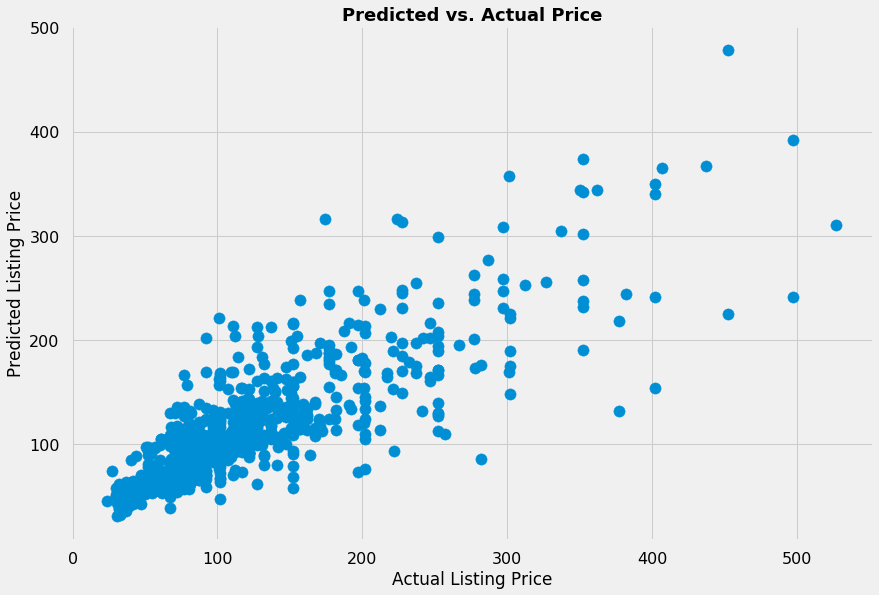

In [70]:
# train and test
model = LGBMRegressor()

trained_model = train_and_test(transformed_df, model)

The above visualisation suggests the model generalizes quite decently for prices below 200, which is good, considering, most of the listing prices are under 200. 
Also, the model we built is a basic one and there is scope for improving the model further.
Here are some of the steps we can take to improve the model:
a) Include all the amenities in separate columns since some amenities are more preferred and costlier than others.
b) Experiment with different threshold values for missing values, correlation coefficient for feature selection.
c) Use more realistic values for missing value imputation. For instance, missing values for security deposit and cleaning fee suggests those listings do not charge extra fees for security deposit and cleaing. So, it would be more appropriate to impute the missing values with zeroes instead of mean.
c) Hyperparamter tuning to improve model accuracy.

Next, let's use the properties of the trained model to get a list of most important features and their relative importance in predicting a listing price.

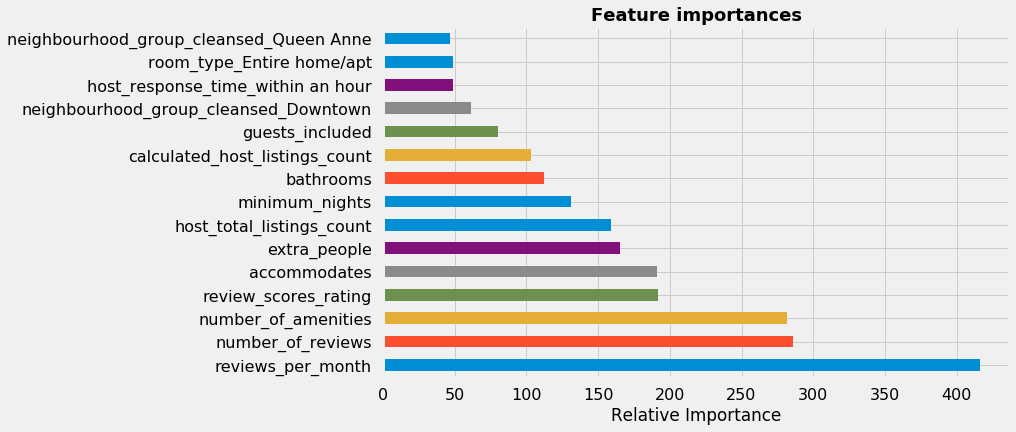

In [71]:
feat_imp = pd.Series(trained_model.feature_importances_,
                     index=transformed_df.columns.drop('price'))
feat_imp.nlargest(15).plot(kind='barh', figsize=(10, 6))
plt.xlabel('Relative Importance')
plt.title("Feature importances", fontsize=18, fontweight='bold')
plt.show()

Number of reviews and amenities along with review scores rating, total listings count and accommodates seem to be most important features in listing price prediction. Another thing to note here, is that accommodates, extra people, bathrooms and guests included are all related to the size of the rental property and play an important role in determining the listing price.

# Conclusion

We explored Airbnb listings in Seattle for 2016 to find answers for some of the questions we had related to how Airbnb is being used. Some of the answers were conclusive, for instance, number of reviews, amenities, and area of the ‘living space’ play an important role in determining the price of a listing. Some of the questions require more data to draw better conclusions. For instance, the number of listings in some of the neighborhoods were too small to get a generalized trend. We will need to combine data from different years to see if the patterns seen in the data hold across the years. Also, as a possible next step, we can look into data from different cities to see how they compare with each other.